In [102]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

<h2>Plotando as linhas equipotenciais para o caso básico (sem nenhum objeto entre as placas parelelas):</h2>

In [125]:
basico_df = pd.read_excel('./dados/experimento_base.xlsx')

In [104]:
def plot_contour(df):
  '''
  Plota uma curva de nivel usando os dados de df
  '''
  plt.tricontour(df['x'], df['y'], df['mV'])

  # plt.plot(df['x'], basico_df['y'], ls='', marker='.') # Plota cada ponto q foi utilizado para criar as curvas

  plt.ylim(bottom=0)
  plt.xlabel('X(cm)')
  plt.ylabel('Y(cm)')

  plt.show()

<h3>Distribuição dos pontos que foram utilizados para coletar os dados</h3>

/usr/local/lib/python3.9/dist-packages/pandas/plotting/_matplotlib/core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


<Axes: xlabel='x', ylabel='y'>

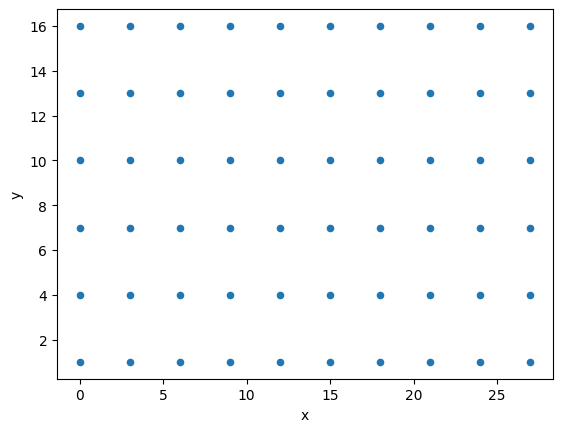

In [105]:
basico_df.plot(kind='scatter', x='x', y='y')

<h3>As linhas equipotenciais desse experimento</h3>

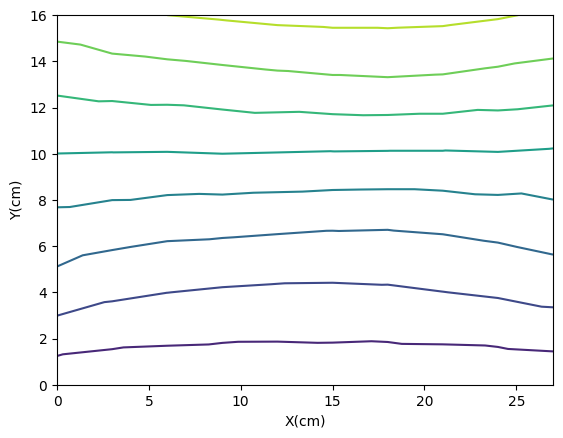

In [106]:
plot_contour(basico_df)

<h2>Plotando as linhas equipotenciais para o caso com a ponta entre as placas paralelas:</h2>

In [126]:
partial_ponta_df = pd.read_excel('./dados/experimento_ponta.xlsx')

In [108]:
def sum_and_append(arr, value, increment, iterations):
  for _ in range(iterations):
    value += increment
    arr.append(value)
  
  return value

In [127]:
def complete_df(df):
  '''
  Recebe um df que possui os dados da coluna x incompletos(so foram medidos até metade da folha) e os da coluna y completos, com isso completa 
  df obtendo os pontos faltantes a partir dos pontos coletados utilizando simetria em torno do eixo y
  '''

  y_vals = df['y'].unique()

  final_df = pd.DataFrame(columns=['x', 'y', 'mV']) # cria o df q sera o output

  for val in y_vals:
    selected_y_val_df = df[df['y'] == val].sort_values(by='x') # pega apenas as linhas com um valor de y especifico

    decrescent_x_vals = list(selected_y_val_df['x'].sort_values(ascending=False))

    # esses sao os unicos intervalos possiveis dos df que serão utilizados
    sum_half = 0 # numero de vezes que deve somar .5
    sum_one = 0 # numero de vezes que deve somar 1
    sum_two = 0 # numero de vezes que deve somar 2
    sum_three = 0 # numero de vezes que deve somar 3

    for i in range(len(decrescent_x_vals) - 1):
      diference = decrescent_x_vals[i] - decrescent_x_vals[i + 1]

      if diference == 3:
        sum_three += 1
      elif diference == 2:
        sum_two += 1
      elif diference == 1:
        sum_one += 1
      elif diference == .5:
        sum_half += 1

    max_x_val = int(df['x'].max()) # pega o maior valor de x para ir fazendo as adicoes

    y_vals = np.array([val] * (sum_half + sum_one + sum_two + sum_three))

    # cria um array com os novos valores de x
    x_vals = []
    max_x_val = sum_and_append(x_vals, max_x_val, .5, sum_half)
    max_x_val = sum_and_append(x_vals, max_x_val, 1, sum_one)
    max_x_val = sum_and_append(x_vals, max_x_val, 2, sum_two)
    max_x_val = sum_and_append(x_vals, max_x_val, 3, sum_three)
    x_vals = np.array(x_vals)

    inverted_mv = np.array(selected_y_val_df['mV'][-2::-1])

    inverted_selected_df = pd.DataFrame({'y': y_vals, 'x': x_vals, 'mV': inverted_mv})
    
    final_selected_df = pd.concat([selected_y_val_df, inverted_selected_df])

    final_df = pd.concat([final_df, final_selected_df])

  return final_df.astype(int)

In [110]:
ponta_df = complete_df(partial_ponta_df)

<h3>Distribuição dos pontos que foram utilizados para coletar os dados</h3>

/usr/local/lib/python3.9/dist-packages/pandas/plotting/_matplotlib/core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


<Axes: xlabel='x', ylabel='y'>

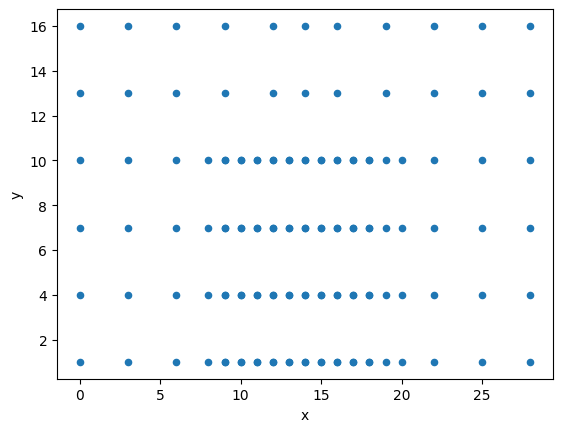

In [111]:
ponta_df[['x', 'y']].plot(kind='scatter', x='x', y='y')

In [128]:
# os valores de mV == 0 são valores que não foram possíveis de medir por conta do objeto estar sobre o ponto, precisa remover esses valores 
# pois eles alteram o desenho das curvas de nível
def remove_zero_values(df, column):
  '''
  Remove as linhas de df em que os valores da coluna column sejam iguais a 0
  '''
  df[column] = df[column].replace(0, np.NaN)
  df = df.dropna()
  return df

In [113]:
ponta_df = remove_zero_values(ponta_df, 'mV')

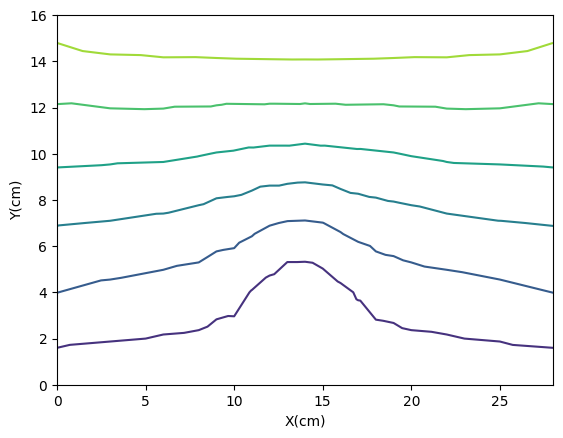

In [114]:
plot_contour(ponta_df)

Plotando as linhas equipotenciais para o caso do anel

In [129]:
partial_ring_df = pd.read_excel('./dados/experimento_anel.xlsx')

In [116]:
ring_df = complete_df(partial_ring_df)

<h3>Distribuição dos pontos que foram utilizados para coletar os dados</h3>

/usr/local/lib/python3.9/dist-packages/pandas/plotting/_matplotlib/core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


<Axes: xlabel='x', ylabel='y'>

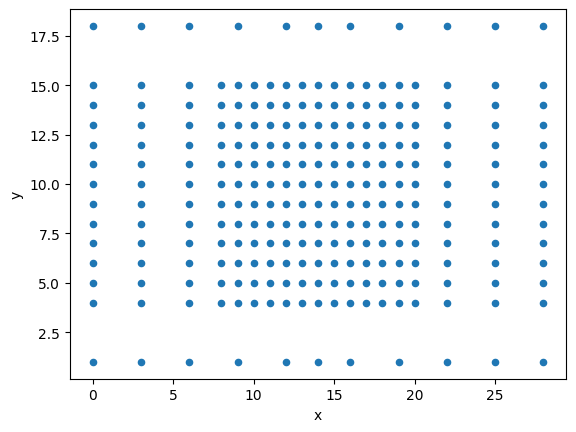

In [117]:
ring_df.plot(kind='scatter', x='x', y='y')

In [118]:
# remove as linhas que tem mV == 0, pois nesses pontos nao foi possivel medir por conta do anel
ring_df = remove_zero_values(ring_df, 'mV')

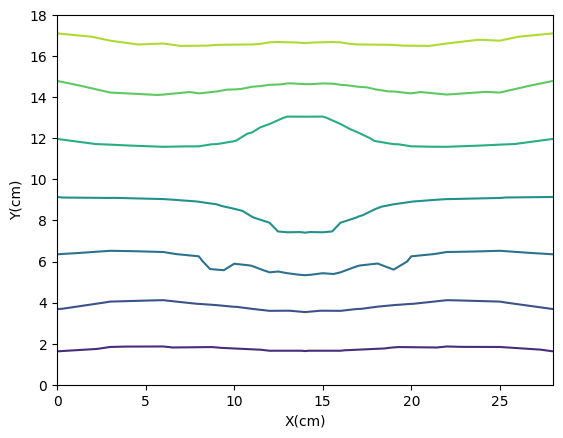

In [119]:
plot_contour(ring_df)

<h3>Usando os pontos coletados no eixo de simetria de cada experimento, será plotado um gráfico do potencial elétrico em função da posição da ponta ao longo do eixo de simetria(y)</h3>

In [130]:
# importa o df que possui todos os dados
all_simetric_df = pd.read_excel('./dados/experimento_eixo_simetria.xlsx')

In [121]:
# cria dfs que representam cada experimento
base_simetric_df = all_simetric_df.drop(columns=['V(Ponta)', 'V(Anel)']).rename(columns={'Altura(Y)': 'y', 'V(Base)': 'mV'}).dropna() # unico q pode conter valores nulos
ponta_simetric_df = all_simetric_df.drop(columns=['V(Base)', 'V(Anel)']).rename(columns={'Altura(Y)': 'y', 'V(Ponta)': 'mV'})
anel_simetric_df = all_simetric_df.drop(columns=['V(Base)', 'V(Ponta)']).rename(columns={'Altura(Y)': 'y', 'V(Anel)': 'mV'})

<h3>Gráfico dos pontos no eixo de simetria do experimento com placas paralelas</h3>

/usr/local/lib/python3.9/dist-packages/pandas/plotting/_matplotlib/core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


<Axes: xlabel='mV', ylabel='y'>

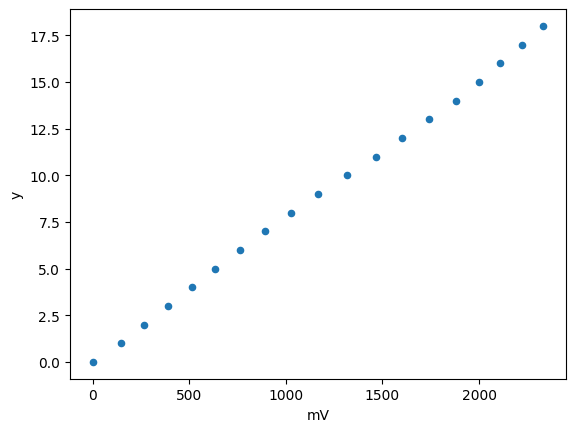

In [122]:
base_simetric_df.plot(kind='scatter', x='mV', y='y')

<h3>Gráfico dos pontos no eixo de simetria do experimento com ponta</h3>

/usr/local/lib/python3.9/dist-packages/pandas/plotting/_matplotlib/core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


<Axes: xlabel='mV', ylabel='y'>

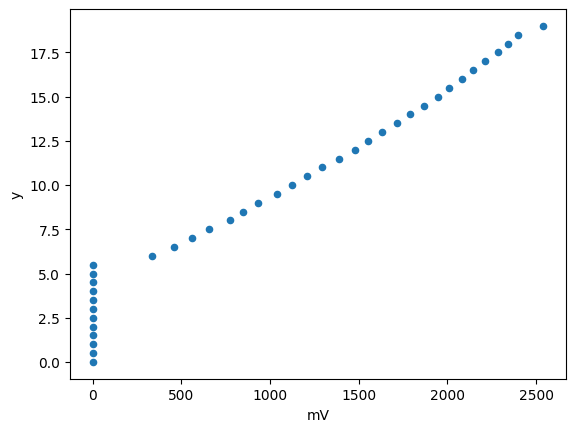

In [131]:
ponta_simetric_df.plot(kind='scatter', x='mV', y='y')

# nesse plot os pontos com valores de mV == 0 são pontos que não foram possíveis de medir, pois a ponta estava sobre eles

<h3>Gráfico dos pontos no eixo de simetria do experimento com o anel</h3>

<Axes: xlabel='mV', ylabel='y'>

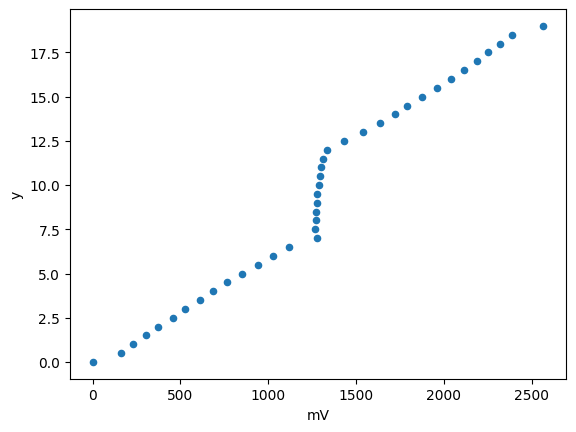

In [124]:
anel_simetric_df.plot(kind='scatter', x='mV', y='y')